In [ ]:
###############################################################################
#  ANÁLISIS ESTADÍSTICO DE ACCIDENTES DE TRÁFICO
#  Autor: Sergio Gómez García
#  Objetivo: Limpieza, análisis descriptivo, modelos inferenciales y HURDLE
###############################################################################

library(tidyverse)
library(janitor)
library(MASS)
library(pscl)
library(broom)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Classes and Methods for R originally developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University (2002-2015),
by and under the direction of Simon Jackman.
hurdle and zeroinfl functions by Achim Zeileis.



In [ ]:
install.packages("janitor")
install.packages("GGally")
install.packages("pscl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snakecase’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’




In [ ]:
# 1. IMPORTACIÓN DE DATOS

ruta_fichero <- "/content/ACCIDENTES-DEFINITIVOS3.csv"

acc <- read.csv(ruta_fichero,
                header = TRUE,
                sep = ";",
                stringsAsFactors = FALSE,
                check.names = FALSE)

dim(acc)   # Nº de filas y columnas
str(acc)   # Estructura general

[1] 101306     68

'data.frame':	101306 obs. of  68 variables:
 $ ANYO                    : int  2023 2023 2023 2023 2023 2023 2023 2023 2023 2023 ...
 $ MES                     : chr  "ENERO" "ENERO" "ENERO" "ENERO" ...
 $ DIA_SEMANA              : chr  "LUNES" "LUNES" "MARTES" "JUEVES" ...
 $ HORA                    : int  7 5 9 13 3 15 15 16 8 18 ...
 $ COD_PROVINCIA           : chr  "ALAVA" "ALAVA" "ALAVA" "ALAVA" ...
 $ ISLA                    : chr  "NO APLICA" "NO APLICA" "NO APLICA" "NO APLICA" ...
 $ ZONA                    : chr  "CARRETERA" "CARRETERA" "CALLE" "CARRETERA" ...
 $ ZONA_AGRUPADA           : chr  "VIAS INTERURBANAS" "VIAS INTERURBANAS" "VIAS URBANAS" "VIAS INTERURBANAS" ...
 $ SENTIDO_1F              : chr  "DESCENDENTE" "DESCENDENTE" "DESCONOCIDO" "DESCENDENTE" ...
 $ TITULARIDAD_VIA         : chr  "PROVINCIAL" "PROVINCIAL" "MUNICIPAL" "PROVINCIAL" ...
 $ TIPO_VIA                : chr  "AUTOVIA" "AUTOVIA" "CALLE" "CARRETERA DE SENTIDO UNICO" ...
 $ TIPO_ACCIDENTE          : chr  

In [ ]:
# 2. LIMPIEZA BÁSICA Y TIPIFICACIÓN

# Convertir todas las cadenas a MAYÚSCULAS sin espacios sobrantes
acc <- acc %>%
  mutate(across(where(is.character),
                ~ toupper(trimws(.x))))

# Variables categóricas que deben ser factor
vars_factor <- c("MES", "DIA_SEMANA", "COD_PROVINCIA", "ISLA",
                 "ZONA", "ZONA_AGRUPADA", "SENTIDO_1F",
                 "TITULARIDAD_VIA", "TIPO_VIA",
                 "TIPO_ACCIDENTE",
                 "NUDO", "NUDO_INFO",
                 "PRIORI_NORMA", "PRIORI_AGENTE", "PRIORI_SEMAFORO",
                 "PRIORI_VERT_STOP", "PRIORI_VERT_CEDA",
                 "PRIORI_HORIZ_STOP", "PRIORI_HORIZ_CEDA",
                 "PRIORI_MARCAS", "PRIORI_PEA_NO_ELEV",
                 "PRIORI_PEA_ELEV", "PRIORI_MARCA_CICLOS",
                 "PRIORI_CIRCUNSTANCIAL", "PRIORI_OTRA",
                 "CONDICION_NIVEL_CIRCULA",
                 "CONDICION_FIRME", "CONDICION_ILUMINACION",
                 "CONDICION_METEO", "CONDICION_NIEBLA",
                 "CONDICION_VIENTO", "VISIB_RESTRINGIDA_POR",
                 "ACERA", "TRAZADO_PLANTA")

vars_factor <- intersect(vars_factor, names(acc))

acc <- acc %>%
  mutate(across(all_of(vars_factor), factor))

# Variables numéricas clave
vars_num <- c("TOTAL_VICTIMAS_24H", "TOTAL_MU24H",
              "TOTAL_HG24H", "TOTAL_HL24H")

vars_num <- intersect(vars_num, names(acc))

summary(acc[vars_num])

 TOTAL_VICTIMAS_24H  TOTAL_MU24H       TOTAL_HG24H       TOTAL_HL24H    
 Min.   : 1.000     Min.   :0.00000   Min.   :0.00000   Min.   : 0.000  
 1st Qu.: 1.000     1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.: 1.000  
 Median : 1.000     Median :0.00000   Median :0.00000   Median : 1.000  
 Mean   : 1.336     Mean   :0.01519   Mean   :0.09386   Mean   : 1.227  
 3rd Qu.: 1.000     3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.: 1.000  
 Max.   :48.000     Max.   :4.00000   Max.   :7.00000   Max.   :42.000  

TIPO_ACCIDENTE,n,percent
<fct>,<dbl>,<chr>
ATROPELLO,13217,13.0%
CAIDA,8458,8.3%
COLISION,53593,52.9%
MULTIPLE,2107,2.1%
OTRO TIPO DE ACCIDENTE,4590,4.5%
SALIDA DE LA VIA,15665,15.5%
VUELCO,3676,3.6%


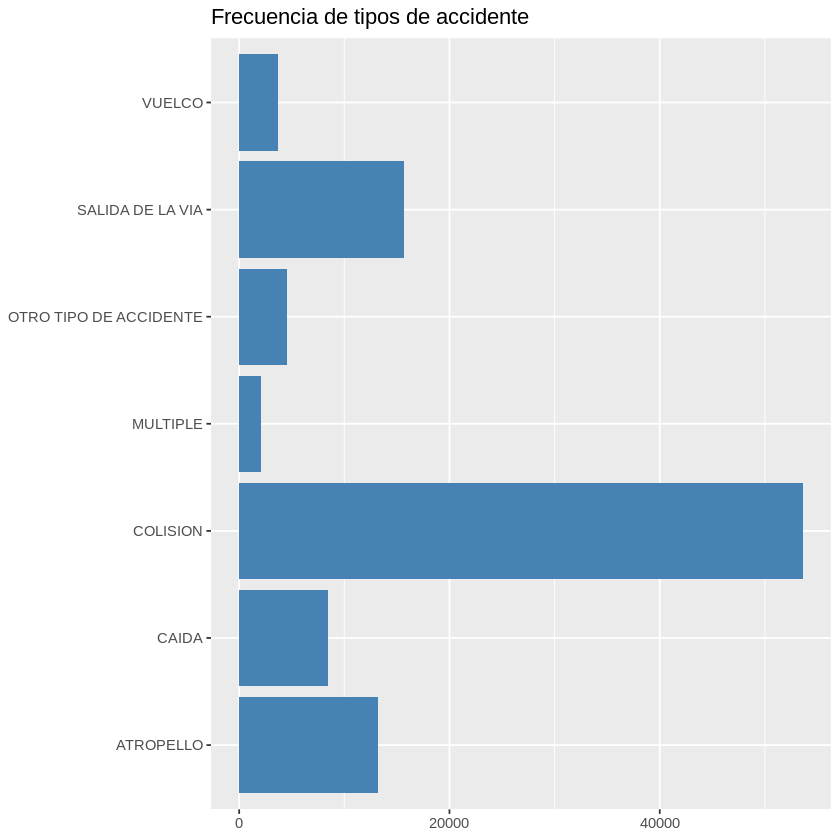

In [ ]:
# 3. ANÁLISIS DESCRIPTIVO (TABLAS Y GRÁFICOS)

# Tipos de accidente
tabla_tipo <- acc %>%
  tabyl(TIPO_ACCIDENTE) %>%
  adorn_pct_formatting(digits = 1)

tabla_tipo

ggplot(acc, aes(x = TIPO_ACCIDENTE)) +
  geom_bar(fill = "steelblue") +
  coord_flip() +
  labs(title = "Frecuencia de tipos de accidente") +
  theme(axis.title = element_blank())

MES,n,percent
<fct>,<dbl>,<chr>
ENERO,7964,7.9%
FEBRERO,7115,7.0%
MARZO,8508,8.4%
ABRIL,8656,8.5%
MAYO,8804,8.7%
JUNIO,8840,8.7%
JULIO,9238,9.1%
AGOSTO,8197,8.1%
SEPTIEMBRE,8322,8.2%


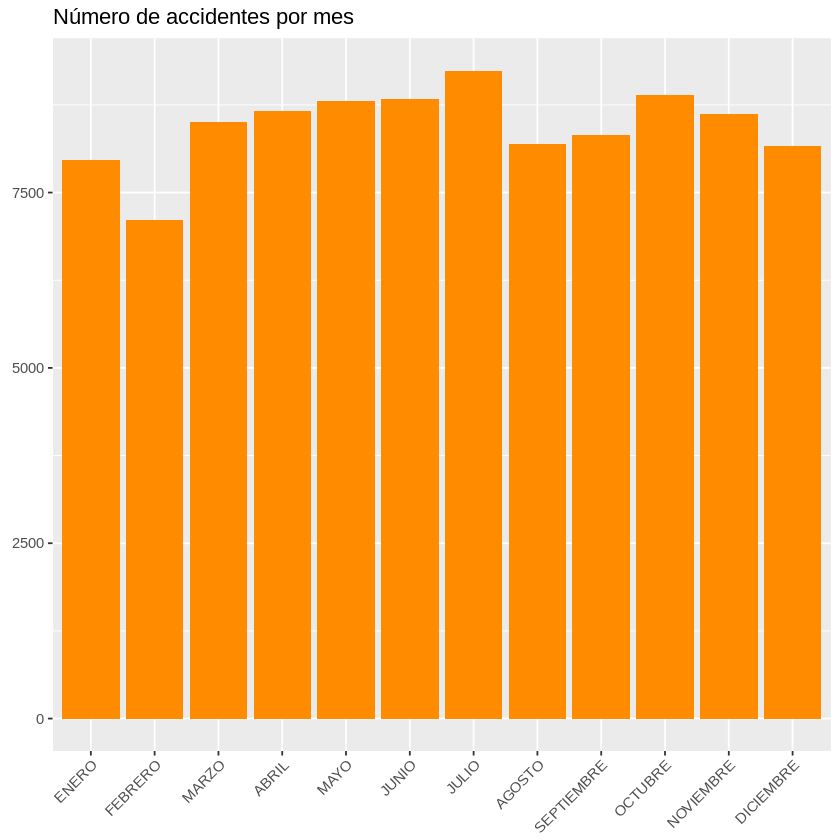

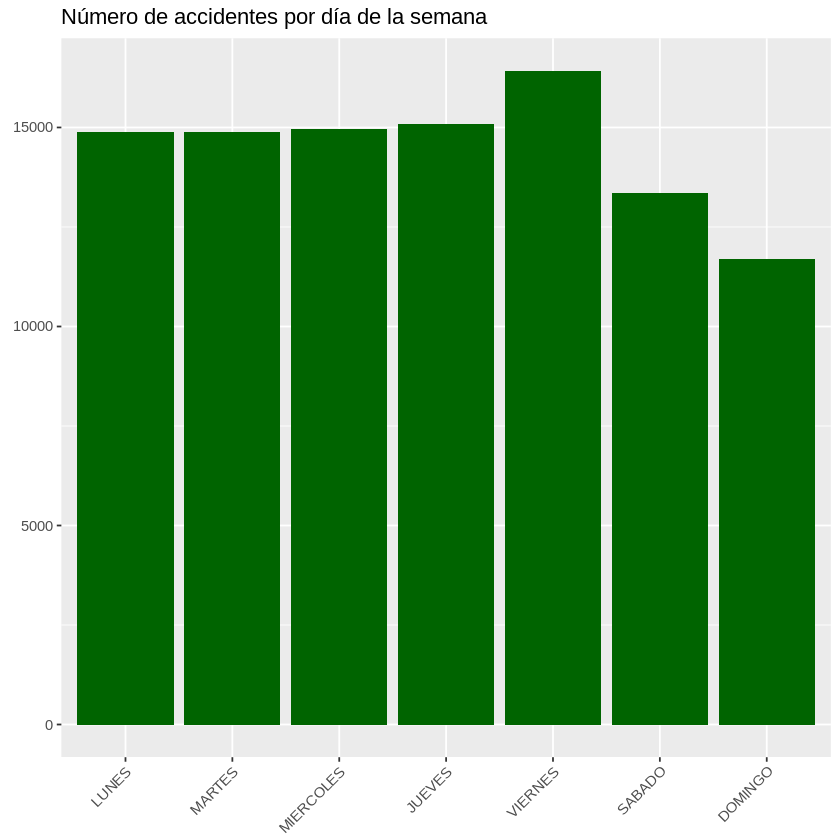

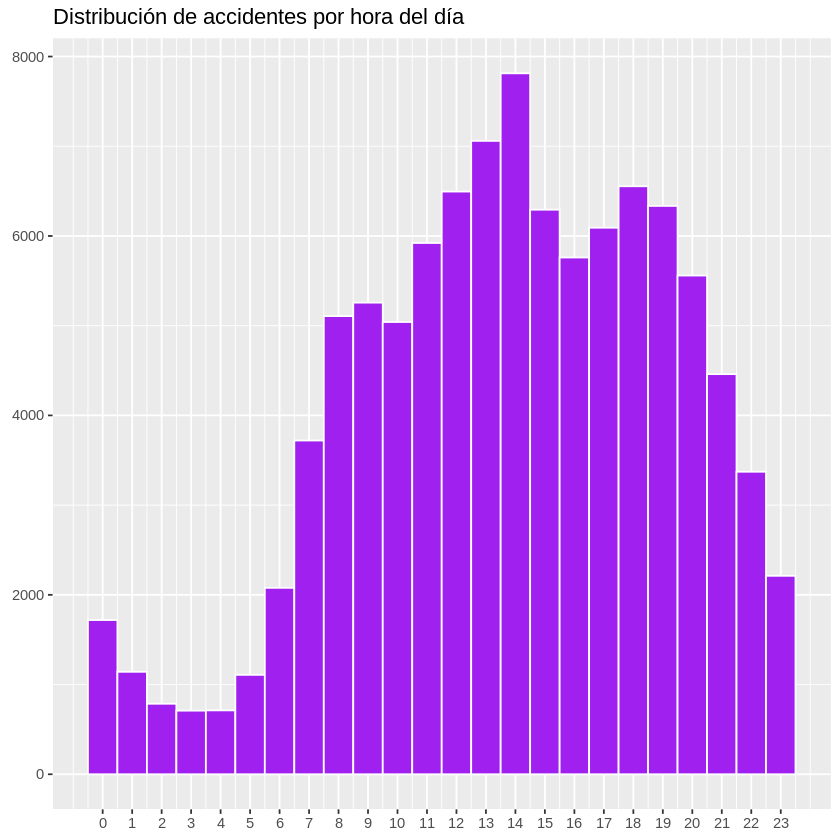

In [ ]:
# Accidentes por mes
acc <- acc %>%
  mutate(
    MES = factor(
      MES,
      levels = c("ENERO","FEBRERO","MARZO","ABRIL","MAYO","JUNIO",
                 "JULIO","AGOSTO","SEPTIEMBRE","OCTUBRE","NOVIEMBRE","DICIEMBRE")
    )
  )

tabla_mes <- acc %>%
  tabyl(MES) %>%
  adorn_pct_formatting(digits = 1)

tabla_mes

ggplot(acc, aes(x = MES)) +
  geom_bar(fill = "darkorange") +
  labs(title = "Número de accidentes por mes") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(axis.title = element_blank())

# Accidentes por día de la semana
acc <- acc %>%
  mutate(
    DIA_SEMANA = factor(
      DIA_SEMANA,
      levels = c("LUNES","MARTES","MIERCOLES","JUEVES","VIERNES","SABADO","DOMINGO")
    )
  )

# Accidentes por día de la semana
ggplot(acc, aes(x = DIA_SEMANA)) +
  geom_bar(fill = "darkgreen") +
  labs(title = "Número de accidentes por día de la semana") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(axis.title = element_blank())

# Accidentes por hora
ggplot(acc, aes(x = HORA)) +
  geom_histogram(binwidth = 1, fill = "purple", color = "white") +
  scale_x_continuous(breaks = 0:23) +
  labs(title = "Distribución de accidentes por hora del día") +
  theme(axis.title = element_blank())

TIPO_ACCIDENTE,n,media_vict,mediana_vict,sd_vict
<fct>,<int>,<dbl>,<dbl>,<dbl>
MULTIPLE,2107,2.227812,2,1.5735604
COLISION,53593,1.407348,1,0.8666951
OTRO TIPO DE ACCIDENTE,4590,1.346187,1,0.9266999
SALIDA DE LA VIA,15665,1.334568,1,0.9131576
ATROPELLO,13217,1.130968,1,0.4100632
VUELCO,3676,1.114799,1,0.4025615
CAIDA,8458,1.074604,1,0.3166435


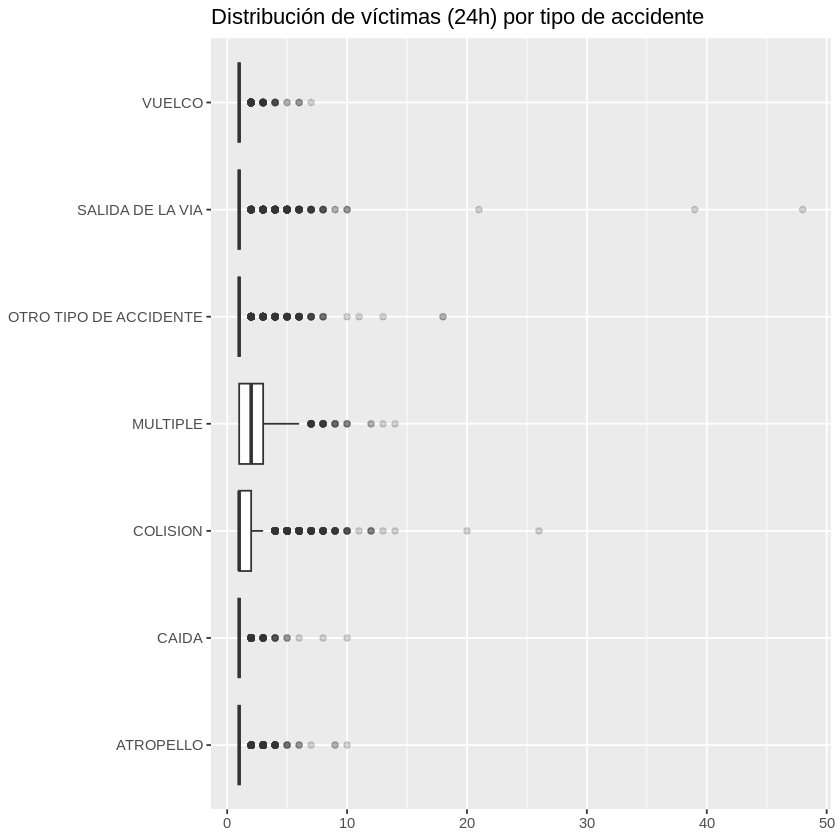

In [ ]:
acc_sev <- acc %>%
  filter(!is.na(TOTAL_VICTIMAS_24H))

desc_severidad <- acc %>%
  group_by(TIPO_ACCIDENTE) %>%
  summarise(
    n = n(),
    media_vict = mean(TOTAL_VICTIMAS_24H, na.rm = TRUE),
    mediana_vict = median(TOTAL_VICTIMAS_24H, na.rm = TRUE),
    sd_vict = sd(TOTAL_VICTIMAS_24H, na.rm = TRUE)
  ) %>%
  arrange(desc(media_vict))

desc_severidad

# Boxplot de víctimas por tipo de accidente
ggplot(acc, aes(x = TIPO_ACCIDENTE, y = TOTAL_VICTIMAS_24H)) +
  geom_boxplot(outlier.alpha = 0.2) +
  coord_flip() +
  labs(title = "Distribución de víctimas (24h) por tipo de accidente") +
  theme(axis.title = element_blank())

,TIPO_ACCIDENTE,VIAS INTERURBANAS,VIAS URBANAS
,<fct>,<chr>,<chr>
1,ATROPELLO,9.7%,90.3%
2,CAIDA,16.8%,83.2%
3,COLISION,32.0%,68.0%
4,MULTIPLE,61.8%,38.2%
5,OTRO TIPO DE ACCIDENTE,21.1%,78.9%
6,SALIDA DE LA VIA,77.2%,22.8%
7,VUELCO,30.4%,69.6%
8,Total,34.9%,65.1%


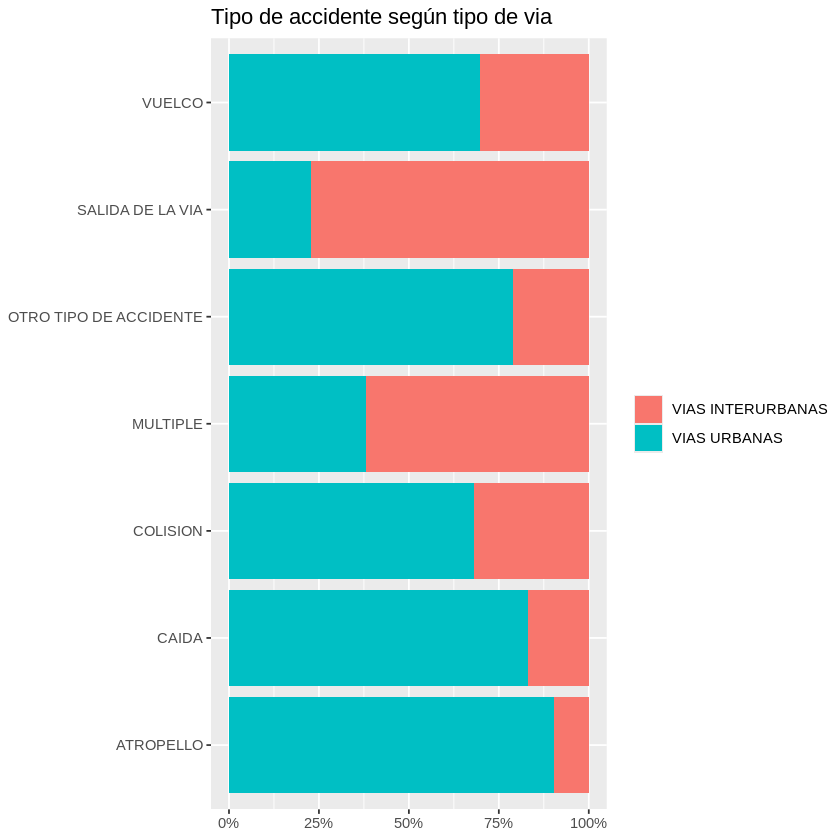

In [ ]:
tabla_tipo_zona <- acc %>%
  tabyl(TIPO_ACCIDENTE, ZONA_AGRUPADA) %>%
  adorn_totals("row") %>%
  adorn_percentages("row") %>%
  adorn_pct_formatting(digits = 1)

tabla_tipo_zona

# Gráfico de barras apiladas
ggplot(acc, aes(x = TIPO_ACCIDENTE, fill = ZONA_AGRUPADA)) +
  geom_bar(position = "fill") +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Tipo de accidente según tipo de via", fill = NULL) +
  theme(axis.title = element_blank())

In [ ]:
# 4. INFERENCIA ESTADÍSTICA

ic_global <- t.test(acc_sev$TOTAL_VICTIMAS_24H,
                    conf.level = 0.95)

ic_global$conf.int      # IC 95% para la media
ic_global$estimate      # media muestral

[1] 1.330836 1.341030
attr(,"conf.level")
[1] 0.95

mean of x 
 1.335933

In [ ]:
# IC por tipo de accidente

ic_por_grupo <- acc_sev %>%
  group_by(TIPO_ACCIDENTE) %>%
  group_modify(~{
    tt <- t.test(.x$TOTAL_VICTIMAS_24H)
    tibble(
      media = tt$estimate,
      ic_inf = tt$conf.int[1],
      ic_sup = tt$conf.int[2]
    )
  })

ic_por_grupo

TIPO_ACCIDENTE,media,ic_inf,ic_sup
<fct>,<dbl>,<dbl>,<dbl>
ATROPELLO,1.130968,1.123976,1.137959
CAIDA,1.074604,1.067855,1.081353
COLISION,1.407348,1.400010,1.414686
MULTIPLE,2.227812,2.160584,2.295040
OTRO TIPO DE ACCIDENTE,1.346187,1.319371,1.373003
SALIDA DE LA VIA,1.334568,1.320267,1.348868
VUELCO,1.114799,1.101781,1.127816


In [ ]:
# Comparación: colisión vs salida de vía

tipos_2 <- c("COLISION", "SALIDA DE LA VIA")
datos_2 <- acc_sev %>%
  filter(TIPO_ACCIDENTE %in% tipos_2)

t_test_2 <- t.test(TOTAL_VICTIMAS_24H ~ TIPO_ACCIDENTE,
                   data = datos_2)

t_test_2


	Welch Two Sample t-test

data:  TOTAL_VICTIMAS_24H by TIPO_ACCIDENTE
t = 8.8752, df = 24502, p-value < 2.2e-16
alternative hypothesis: true difference in means between group COLISION and group SALIDA DE LA VIA is not equal to 0
95 percent confidence interval:
 0.05670718 0.08885375
sample estimates:
        mean in group COLISION mean in group SALIDA DE LA VIA 
                      1.407348                       1.334568 


In [ ]:
# Proporción de accidentes urbanos vs interurbanos

tabla_zona <- acc %>%
  filter(ZONA_AGRUPADA %in% c("VIAS URBANAS", "VIAS INTERURBANAS")) %>%
  tabyl(ZONA_AGRUPADA)

tabla_zona

# Proporción de accidentes en cada zona
x_urb <- tabla_zona$n[tabla_zona$ZONA_AGRUPADA == "VIAS URBANAS"]
n_total <- sum(tabla_zona$n)

prop_test <- prop.test(x = x_urb, n = n_total, p = 0.5)

prop_test

ZONA_AGRUPADA,n,percent
<fct>,<int>,<dbl>
VIAS INTERURBANAS,35330,0.3487454
VIAS URBANAS,65976,0.6512546



	1-sample proportions test with continuity correction

data:  x_urb out of n_total, null probability 0.5
X-squared = 9270.1, df = 1, p-value < 2.2e-16
alternative hypothesis: true p is not equal to 0.5
95 percent confidence interval:
 0.6483093 0.6541884
sample estimates:
        p 
0.6512546 


In [ ]:
# 5. MODELOS: LM, NB y HURDLE

# Preparamos las variables
acc_reg <- acc_sev %>%
  mutate(
    HORA_NUM = HORA,
    LABORAL = if_else(DIA_SEMANA %in% c("SABADO", "DOMINGO"),
                      "FIN_DE_SEMANA", "LABORAL")
  ) %>%
  mutate(LABORAL = factor(LABORAL)) %>%
  droplevels()

# 5.1 Modelo lineal
mod_lm <- lm(TOTAL_VICTIMAS_24H ~ HORA_NUM +
               ZONA_AGRUPADA +
               CONDICION_METEO +
               CONDICION_ILUMINACION +
               TIPO_ACCIDENTE +
               LABORAL,
             data = acc_reg)

summary(mod_lm)  # coeficientes, p-valores, R², etc.
tidy(mod_lm)


Call:
lm(formula = TOTAL_VICTIMAS_24H ~ HORA_NUM + ZONA_AGRUPADA + 
    CONDICION_METEO + CONDICION_ILUMINACION + TIPO_ACCIDENTE + 
    LABORAL, data = acc_reg)

Residuals:
   Min     1Q Median     3Q    Max 
-1.630 -0.364 -0.281 -0.001 46.694 

Coefficients:
                                                                              Estimate
(Intercept)                                                                  1.3495537
HORA_NUM                                                                     0.0027583
ZONA_AGRUPADAVIAS URBANAS                                                   -0.2292696
CONDICION_METEODESPEJADO                                                     0.0224389
CONDICION_METEOGRANIZANDO                                                    0.2861989
CONDICION_METEOLLUVIA DEBIL                                                  0.0399168
CONDICION_METEOLLUVIA FUERTE                                                 0.1059343
CONDICION_METEONEVANDO                     

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.349553749,0.0261868159,51.5356184,0.000000e+00
HORA_NUM,0.002758337,0.0004781921,5.7682628,8.032499e-09
ZONA_AGRUPADAVIAS URBANAS,-0.229269637,0.0061038974,-37.5611876,1.211708e-306
CONDICION_METEODESPEJADO,0.022438913,0.0177298405,1.2656015,2.056587e-01
CONDICION_METEOGRANIZANDO,0.286198873,0.1073107096,2.6670113,7.654127e-03
CONDICION_METEOLLUVIA DEBIL,0.039916753,0.0211175228,1.8902195,5.873146e-02
CONDICION_METEOLLUVIA FUERTE,0.105934250,0.0288318020,3.6742154,2.387043e-04
CONDICION_METEONEVANDO,-0.043062674,0.1072864120,-0.4013805,6.881408e-01
CONDICION_METEONUBLADO,0.048653977,0.0207061523,2.3497353,1.878867e-02


In [ ]:
# 5.2 Modelo Binomial Negativa

mod_nb <- glm.nb(
  TOTAL_VICTIMAS_24H ~ HORA_NUM + ZONA_AGRUPADA +
    CONDICION_METEO + CONDICION_ILUMINACION +
    TIPO_ACCIDENTE + LABORAL,
  data = acc_reg
)

summary(mod_nb)
AIC(mod_lm, mod_nb)

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”



Call:
glm.nb(formula = TOTAL_VICTIMAS_24H ~ HORA_NUM + ZONA_AGRUPADA + 
    CONDICION_METEO + CONDICION_ILUMINACION + TIPO_ACCIDENTE + 
    LABORAL, data = acc_reg, init.theta = 52309.151, link = log)

Coefficients:
                                                                              Estimate
(Intercept)                                                                  0.2767403
HORA_NUM                                                                     0.0020407
ZONA_AGRUPADAVIAS URBANAS                                                   -0.1651542
CONDICION_METEODESPEJADO                                                     0.0184063
CONDICION_METEOGRANIZANDO                                                    0.1801100
CONDICION_METEOLLUVIA DEBIL                                                  0.0313707
CONDICION_METEOLLUVIA FUERTE                                                 0.0791472
CONDICION_METEONEVANDO                                                      -0.0315573


,df,AIC
,<dbl>,<dbl>
mod_lm,23,241941.3
mod_nb,23,250658.0


In [ ]:
# 5.3 Modelo HURDLE

acc_reg <- acc_reg %>%
  mutate(
    MAS_DE_UNA = if_else(TOTAL_VICTIMAS_24H > 1, 1, 0),
    EXTRA = TOTAL_VICTIMAS_24H - 1
  )

# Parte logística
mod_log_hurdle <- glm(
  MAS_DE_UNA ~ HORA_NUM + ZONA_AGRUPADA + CONDICION_METEO +
               CONDICION_ILUMINACION + TIPO_ACCIDENTE + LABORAL,
  data = acc_reg,
  family = binomial
)

# Parte NB solo para EXTRA > 0
mod_nb_hurdle <- glm.nb(
  EXTRA ~ HORA_NUM + ZONA_AGRUPADA + CONDICION_METEO +
          CONDICION_ILUMINACION + TIPO_ACCIDENTE + LABORAL,
  data = acc_reg %>% filter(EXTRA > 0)
)

summary(mod_log_hurdle)
summary(mod_nb_hurdle)

# Transformación de coeficientes NB a % real
100 * (exp(coef(mod_nb_hurdle)) - 1)

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”



Call:
glm(formula = MAS_DE_UNA ~ HORA_NUM + ZONA_AGRUPADA + CONDICION_METEO + 
    CONDICION_ILUMINACION + TIPO_ACCIDENTE + LABORAL, family = binomial, 
    data = acc_reg)

Coefficients:
                                                                             Estimate
(Intercept)                                                                 -1.549647
HORA_NUM                                                                     0.008550
ZONA_AGRUPADAVIAS URBANAS                                                   -0.670815
CONDICION_METEODESPEJADO                                                     0.138422
CONDICION_METEOGRANIZANDO                                                    0.120243
CONDICION_METEOLLUVIA DEBIL                                                  0.220475
CONDICION_METEOLLUVIA FUERTE                                                 0.367398
CONDICION_METEONEVANDO                                                       0.242084
CONDICION_METEONUBLADO               


Call:
glm.nb(formula = EXTRA ~ HORA_NUM + ZONA_AGRUPADA + CONDICION_METEO + 
    CONDICION_ILUMINACION + TIPO_ACCIDENTE + LABORAL, data = acc_reg %>% 
    filter(EXTRA > 0), init.theta = 24266.2272, link = log)

Coefficients:
                                                                              Estimate
(Intercept)                                                                  0.2962335
HORA_NUM                                                                     0.0016172
ZONA_AGRUPADAVIAS URBANAS                                                   -0.1223935
CONDICION_METEODESPEJADO                                                    -0.0099778
CONDICION_METEOGRANIZANDO                                                    0.4004418
CONDICION_METEOLLUVIA DEBIL                                                 -0.0216393
CONDICION_METEOLLUVIA FUERTE                                                 0.0408824
CONDICION_METEONEVANDO                                                      -

(Intercept) 
                                                                 34.4784107 
                                                                   HORA_NUM 
                                                                  0.1618461 
                                                  ZONA_AGRUPADAVIAS URBANAS 
                                                                -11.5199832 
                                                   CONDICION_METEODESPEJADO 
                                                                 -0.9928170 
                                                  CONDICION_METEOGRANIZANDO 
                                                                 49.2483911 
                                                CONDICION_METEOLLUVIA DEBIL 
                                                                 -2.1406890 
                                               CONDICION_METEOLLUVIA FUERTE 
                                                                  4.1729577 
                                                     CONDICION_METEONEVANDO 
                                                                -27.4481428 
                                                     CONDICION_METEONUBLADO 
                                                                  1.8669651 
              CONDICION_ILUMINACIONAMANECER O ATARDECER, SIN LUZ ARTIFICIAL 
                                                                  2.4004607 
                                           CONDICION_ILUMINACIONDESCONOCIDO 
                                                                -29.1668893 
                                           CONDICION_ILUMINACIONLUZ NATURAL 
                                                                 -1.9563962 
                         CONDICION_ILUMINACIONSIN LUZ NATURAL NI ARTIFICIAL 
                                                                  6.8692304 
  CONDICION_ILUMINACIONSIN LUZ NATURAL Y CON ILUMINACION ARTIFICIAL APAGADA 
                                                                 -0.8956679 
CONDICION_ILUMINACIONSIN LUZ NATURAL Y CON ILUMINACION ARTIFICIAL ENCENDIDA 
                                                                  0.3912065 
                                                        TIPO_ACCIDENTECAIDA 
                                                                 -3.6681874 
                                                     TIPO_ACCIDENTECOLISION 
                                                                 29.3151685 
                                                     TIPO_ACCIDENTEMULTIPLE 
                                                                 74.6984033 
                                       TIPO_ACCIDENTEOTRO TIPO DE ACCIDENTE 
                                                                 40.6938688 
                                             TIPO_ACCIDENTESALIDA DE LA VIA 
                                                                 19.8548119 
                                                       TIPO_ACCIDENTEVUELCO 
                                                                  0.5839307 
                                                             LABORALLABORAL 
                                                                 -8.2381528

In [ ]:
# 6. MODELO LOGÍSTICO: ACCIDENTES CON MUERTOS

acc_log <- acc %>%
  mutate(
    GRAVE = if_else(TOTAL_MU24H > 0, 1, 0)
  ) %>%
  filter(!is.na(GRAVE)) %>%
  mutate(GRAVE = factor(GRAVE)) %>%
  droplevels()

mod_log <- glm(
  GRAVE ~ ZONA_AGRUPADA + TIPO_ACCIDENTE,
  data = acc_log,
  family = binomial(link = "logit")
)

summary(mod_log)
exp(coef(mod_log))
exp(confint(mod_log))


Call:
glm(formula = GRAVE ~ ZONA_AGRUPADA + TIPO_ACCIDENTE, family = binomial(link = "logit"), 
    data = acc_log)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -2.54926    0.07745 -32.913  < 2e-16 ***
ZONA_AGRUPADAVIAS URBANAS            -1.69260    0.06854 -24.695  < 2e-16 ***
TIPO_ACCIDENTECAIDA                  -1.85376    0.18609  -9.962  < 2e-16 ***
TIPO_ACCIDENTECOLISION               -1.23486    0.08069 -15.304  < 2e-16 ***
TIPO_ACCIDENTEMULTIPLE               -1.94742    0.26181  -7.438 1.02e-13 ***
TIPO_ACCIDENTEOTRO TIPO DE ACCIDENTE -1.22484    0.17796  -6.883 5.88e-12 ***
TIPO_ACCIDENTESALIDA DE LA VIA       -0.58245    0.08731  -6.671 2.53e-11 ***
TIPO_ACCIDENTEVUELCO                 -2.04019    0.25988  -7.850 4.15e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 15033  on 101305  deg

(Intercept)            ZONA_AGRUPADAVIAS URBANAS 
                          0.07813954                           0.18404044 
                 TIPO_ACCIDENTECAIDA               TIPO_ACCIDENTECOLISION 
                          0.15664749                           0.29087613 
              TIPO_ACCIDENTEMULTIPLE TIPO_ACCIDENTEOTRO TIPO DE ACCIDENTE 
                          0.14264179                           0.29380490 
      TIPO_ACCIDENTESALIDA DE LA VIA                 TIPO_ACCIDENTEVUELCO 
                          0.55852963                           0.13000412

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.06700498,0.0907809
ZONA_AGRUPADAVIAS URBANAS,0.16076845,0.2103328
TIPO_ACCIDENTECAIDA,0.10683661,0.2221032
TIPO_ACCIDENTECOLISION,0.24856088,0.3410754
TIPO_ACCIDENTEMULTIPLE,0.08203751,0.2304992
TIPO_ACCIDENTEOTRO TIPO DE ACCIDENTE,0.20409215,0.4108229
TIPO_ACCIDENTESALIDA DE LA VIA,0.47115704,0.6634905
TIPO_ACCIDENTEVUELCO,0.07501045,0.2091695


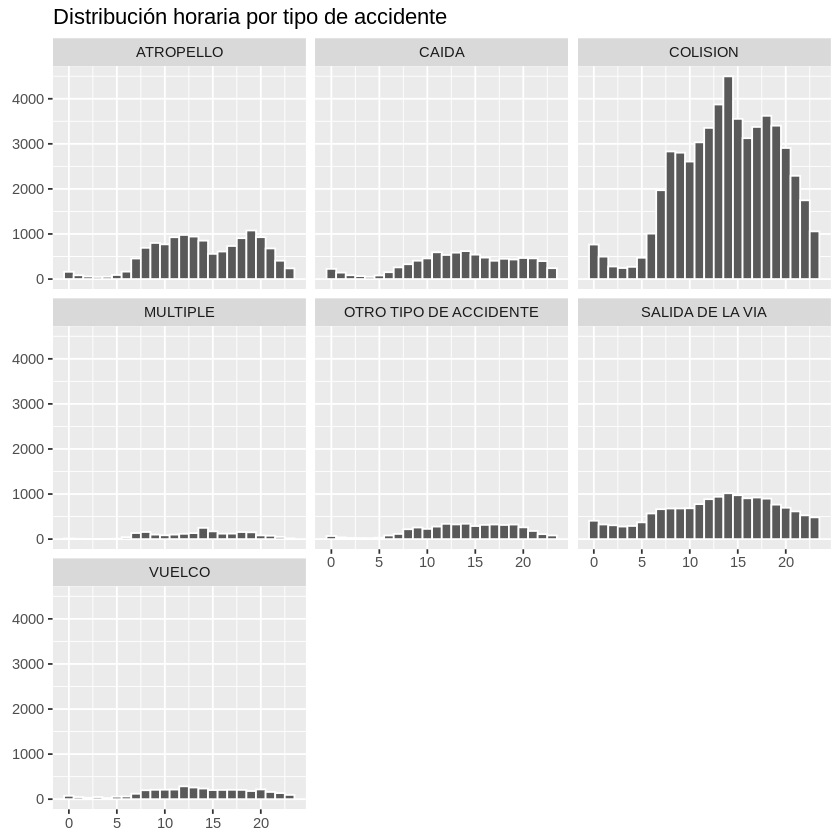

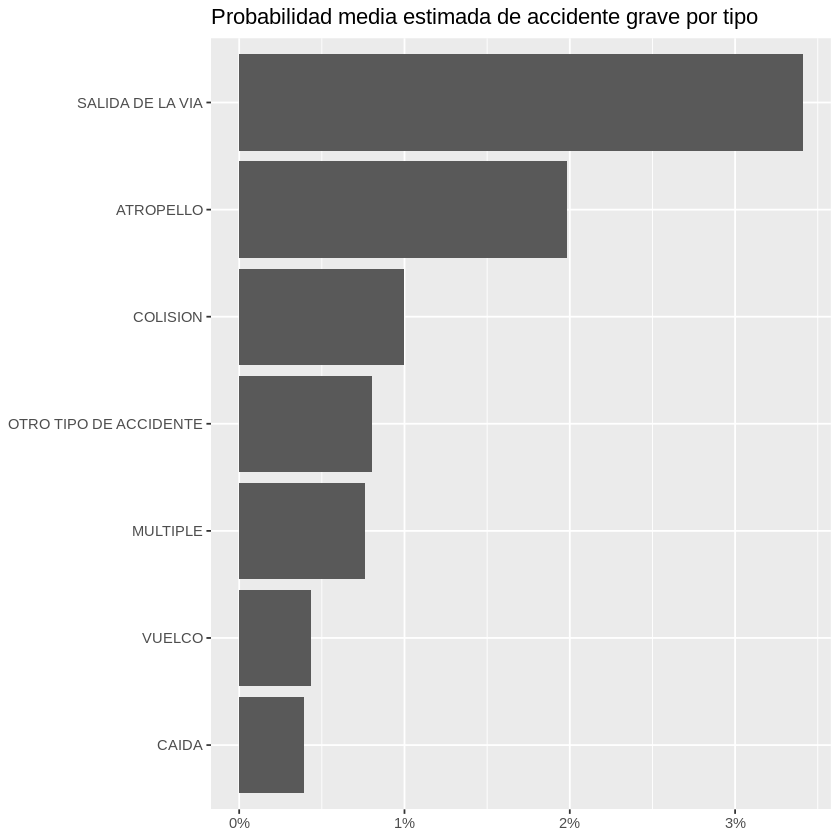

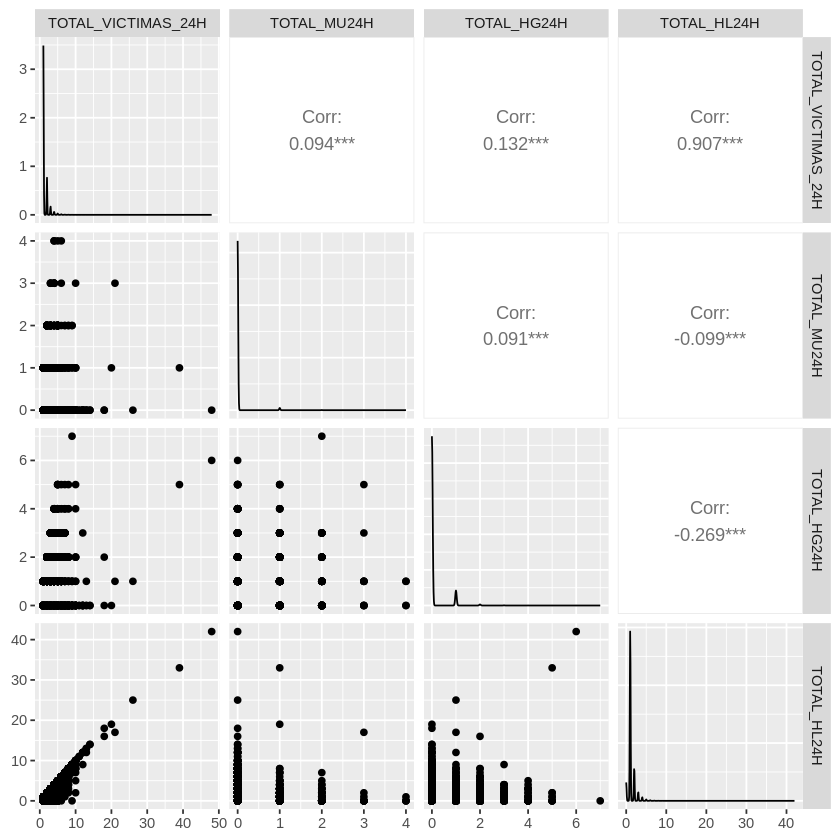

In [ ]:
# 7. GRÁFICOS ADICIONALES

# Distribución horaria por tipo de accidente
ggplot(acc_sev, aes(x = HORA)) +
  geom_histogram(binwidth = 1, color = "white") +
  facet_wrap(~ TIPO_ACCIDENTE, ncol = 3) +
  labs(
    title = "Distribución horaria por tipo de accidente"
  ) + theme(axis.title = element_blank())

# Probabilidad de accidente grave por tipo de accidente
acc_log <- acc_log %>% mutate(prob_grave = predict(mod_log, type = "response"))

prob_por_tipo <- acc_log %>%
  group_by(TIPO_ACCIDENTE) %>%
  summarise(
    prob_grave_media = mean(prob_grave),
    n = n()
  ) %>%
  arrange(desc(prob_grave_media))

ggplot(prob_por_tipo, aes(
  x = fct_reorder(TIPO_ACCIDENTE, prob_grave_media),
  y = prob_grave_media
)) +
  geom_col() +
  coord_flip() +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    title = "Probabilidad media estimada de accidente grave por tipo"
  ) + theme(axis.title = element_blank())

# Matriz de correlaciones
if (length(vars_num) > 1) {
  ggpairs(acc_sev[vars_num])
}